# Spectral Embedding Methods

One of the primary embedding tools you'll use in this book is a set of methods called *spectral embedding* {cite:t}`spectraltutorial`. You'll see spectral embedding and variations on it repeatedly, both throughout this section and when you get into applications, so it's worth taking the time to understand spectral embedding deeply. If you're familiar with Principal Component Analysis (PCA), this method has a lot of similarities. You'll need to get into a bit of linear algebra to understand how it works.

Remember that the basic idea behind any network embedding method is to take the network and put it into Euclidean space - meaning, a nice data table with rows as observations and columns as features (or dimensions), which you can then plot on an x-y axis. In this section, you'll see the linear algebra-centric approach that spectral embedding uses to do this.

Spectral methods are based on a bit of linear algebra, but hopefully a small enough amount to still be understandable. The overall idea has to do with singular vectors, and more generally, something called "singular vectors" - a generalization of singular vectors. It turns out that the biggest singular vectors of a network's adjacency matrix contain the most information about that network - and as the singular vectors get smaller, they contain less information about the network (we're glossing over what 'information' means a bit here, so just think about this as a general intuition). So if you represent a network in terms of its singular vectors, you can drop the smaller ones and still retain most of the information. This is the essence of what spectral embedding is about (here "biggest" means "the singular vector corresponding to the largest singular value").

```{admonition} Singular Values and Singular Vectors
If you don't know what singular values and singular vectors are, don't worry about it. You can think of them as a generalization of eigenvalues/vectors (it's also ok if you don't know what those are): all matrices have singular values and singular vectors, but not all matrices have eigenvalues and eigenvectors. In the case of square, symmetric matrices with positive eigenvalues, the eigenvalues/vectors and singular values/vectors are the same thing.

If you want some more background information on eigenstuff and singularstuff, there are some explanations in the Math Refresher section in the introduction. They're an important set of vectors associated with matrices with a bunch of interesting properties. A lot of linear algebra is built around exploring those properties.
```

You can see visually how Spectral Embedding works below. We start with a 20-node Stochastic Block Model with two communities, and then found its singular values and vectors. It turns out that because there are only two communities, only the first two singular vectors contain information -- the rest are just noise! (you can see this if you look carefully at the first two columns of the singular vector matrix). So, you took these two columns and scaled them by the first two singular vectors of the singular value matrix $D$. The final embedding is that scaled matrix, and the plot you see takes the rows of that matrix and puts them into Euclidean space (an x-y axis) as points. This matrix is called the *latent position matrix*, and the embeddings for the nodes are called the *latent positions*. Underneath the figure is a list that explains how the algorithm works, step-by-step.

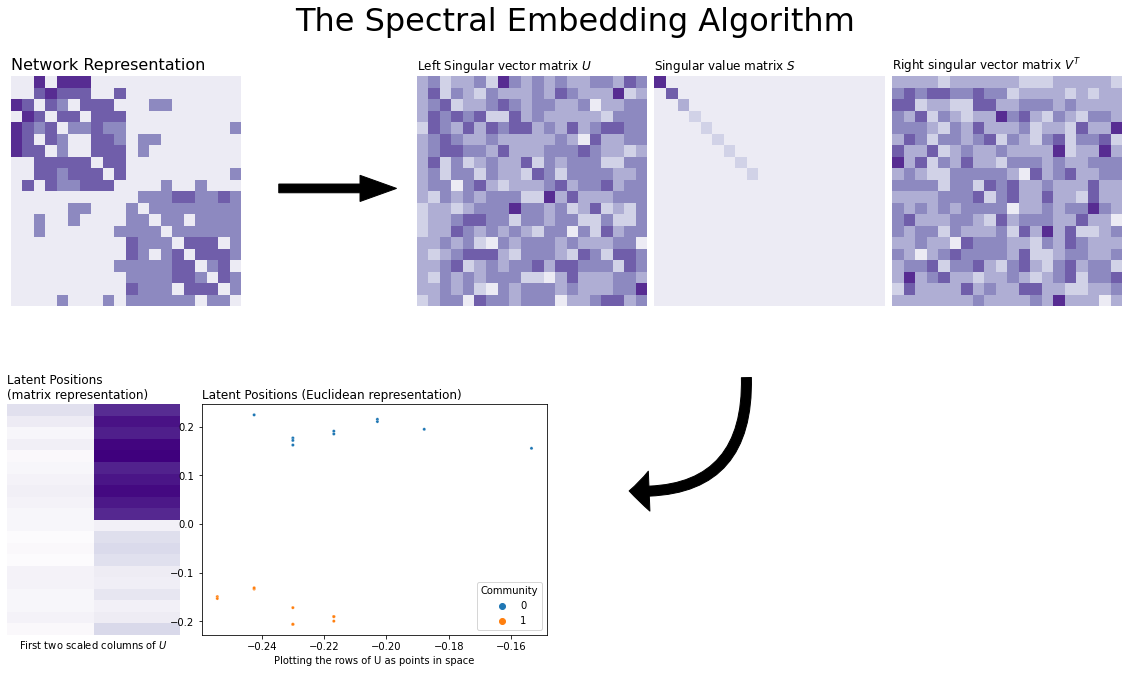

In [20]:
from graspologic.simulations import sbm
from graphbook_code import heatmap, cmaps, plot_latents
from graspologic.utils import to_laplacian
from scipy.linalg import svd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def rm_ticks(ax, x=False, y=False, **kwargs):
    if x is not None:
        ax.axes.xaxis.set_visible(x)
    if y is not None:
        ax.axes.yaxis.set_visible(y)
    sns.despine(ax=ax, **kwargs)

# Make network
B = np.array([[0.8, 0.1], 
              [0.1, 0.8]])
n = [10, 10]
A, labels = sbm(n=n, p=B, return_labels=True)
L = to_laplacian(A)
U, E, Ut = svd(L)
n_components = 2
Uc = U[:, :n_components]
Ec = E[:n_components]
latents = Uc @ np.diag(Ec)
    
fig = plt.figure();

ax = fig.add_axes([.06, -.06, .8, .8]) 
ax = heatmap(L, ax=ax, cbar=False)
ax.set_title("Network Representation", loc="left", fontsize=16)


# add arrow
arrow_ax = fig.add_axes([.8, .3, .3, .1])
rm_ticks(arrow_ax, left=True, bottom=True)
plt.arrow(x=0, y=0, dx=1, dy=0, width=.1, color="black") 

# add joint matrix
ax = fig.add_axes([1, -.02*3, .8, .8])
ax = heatmap(U, ax=ax, cbar=False)
ax.set_title("Left Singular vector matrix $U$", loc="left")

ax = fig.add_axes([1.55, -.06, .8, .8])
ax = heatmap(np.diag(E), ax=ax, cbar=False)
ax.set_title("Singular value matrix $S$", loc="left")

ax = fig.add_axes([2.1, -.06, .8, .8])
ax = heatmap(Ut, ax=ax, cbar=False)
ax.set_title("Right singular vector matrix $V^T$", loc="left")
    
# add second arrow
arrow_ax = fig.add_axes([1.5, -1.2, 1.2, 1])
rm_ticks(arrow_ax, left=True, bottom=True)
style = "Simple, tail_width=10, head_width=40, head_length=20"
kw = dict(arrowstyle=style, color="k", alpha=1)
text_arrow = patches.FancyArrowPatch((0.33, .9), (.1, .5), connectionstyle="arc3, rad=-.55", **kw)
arrow_ax.add_patch(text_arrow)


# Embedding
ax = fig.add_axes([.185, -1.2, .4, .8])
cmap = cmaps["sequential"]
ax = sns.heatmap(latents, cmap=cmap, 
            ax=ax, cbar=False, xticklabels=False, yticklabels=False)
ax.set_title("Latent Positions \n(matrix representation)", loc="left")
ax.set_xlabel("First two scaled columns of $U$")

ax = fig.add_axes([.185+.45, -1.2, .8, .8])
plot_latents(latents, ax=ax, labels=labels)
ax.set_title("Latent Positions (Euclidean representation)", loc="left")
ax.set_xlabel("Plotting the rows of U as points in space")

fig.suptitle("The Spectral Embedding Algorithm", fontsize=32, x=1.5);

```{admonition} The Spectral Embedding Algorithm
1. Take a network's adjacency matrix. Optionally take its Laplacian as a network representation.
2. Decompose it into a a singular vector matrix, a singular value matrix, and the singular vector matrix's transpose.
3. Remove every column of the singular vector matrix except for the first $k$ vectors, corresponding to the $k$ largest singular values.
4. Scale the $k$ remaining columns by their corresponding singular values to create the embedding.
5. The rows of this embedding matrix are the locations in Euclidean space for the nodes of the network (called the latent positions). The embedding matrix is an estimate of the latent position matrix (which we talked about in the 'why embed networks' section)
```

We need to dive into a few specifics to understand spectral embedding better. We need to figure out how to find your network's singular vectors, for instance, and you also need to understand why those singular vectors can be used to form a representation of your network. To do this, we'll explore a few concepts from linear algebra like matrix rank, and we'll see how understanding these concepts connects to understanding spectral embedding.

Let's scale down and make a simple network, with only six nodes. We'll take its Laplacian just to show what that optional step looks like, and then we'll find its singular vectors with a technique we'll explore called Singular Value Decomposition. Then, we'll explore why you can use the first $k$ singular values and vectors to find an embedding. Let's start with creating the simple network.

## A Simple Network

Say you have the simple network below. There are six nodes total, numbered 0 through 5, and there are two distinct connected groups (called "connected components" in network theory land). Nodes 0 through 2 are all connected to each other, and nodes 3 through 5 are also all connected to each other. 

In [21]:
from itertools import combinations
import numpy as np

def add_edge(A, edge: tuple):
    """
    Add an edge to an undirected graph.
    """
    i, j = edge
    A[i, j] = 1
    A[j, i] = 1
    return A

A = np.zeros((6, 6))

for edge in combinations([0, 1, 2], 2):
    add_edge(A, edge)
    
for edge in combinations([3, 4, 5], 2):
    add_edge(A, edge)

You can see the adjacency matrix and network below. Notice that there are two distrinct blocks in the adjacency matrix: in its upper-left, you can see the edges between the first three nodes, and in the bottom right, you can see the edges between the second three nodes.

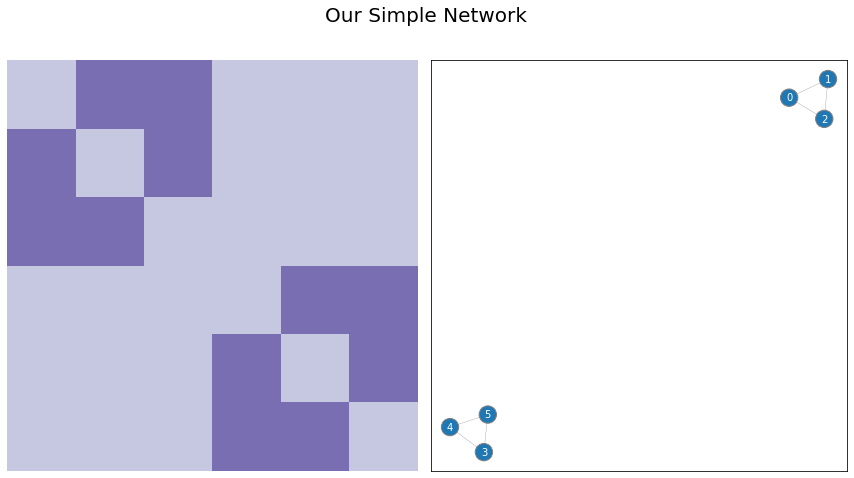

In [22]:
from graphbook_code import draw_multiplot
import networkx as nx

draw_multiplot(A, pos=nx.kamada_kawai_layout, title="Our Simple Network");

## The Laplacian Matrix

With spectral embedding, you'll either find the singular vectors of the Laplacian or the singular vectors of the Adjacency Matrix itself. Since you already have the adjacency matrix, let's take the Laplacian just to see what that looks like.

Remember from chapter four that there are a few different types of Laplacian matrices. By default, for undirected networks, Graspologic uses the normalized Laplacian $L = D^{-1/2} A D^{-1/2}$, where $D$ is the degree matrix. Remember that the degree matrix has the degree, or number of edges, of each node along the diagonals. Variations on the normalized Laplacian are generally what you use in practice, but for simplicity and illustration, you'll just use the basic, cookie-cutter version of the Laplacian $L = D - A$.

Here's the degree matrix $D$.

In [23]:
# Build the degree matrix D
degrees = np.count_nonzero(A, axis=0)
D = np.diag(degrees)
D

array([[2, 0, 0, 0, 0, 0],
       [0, 2, 0, 0, 0, 0],
       [0, 0, 2, 0, 0, 0],
       [0, 0, 0, 2, 0, 0],
       [0, 0, 0, 0, 2, 0],
       [0, 0, 0, 0, 0, 2]])

And here's the Laplacian matrix, written out in full.

In [24]:
# Build the Laplacian matrix L
L = D-A
L

array([[ 2., -1., -1.,  0.,  0.,  0.],
       [-1.,  2., -1.,  0.,  0.,  0.],
       [-1., -1.,  2.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  2., -1., -1.],
       [ 0.,  0.,  0., -1.,  2., -1.],
       [ 0.,  0.,  0., -1., -1.,  2.]])

Below, you can see these matrices visually.

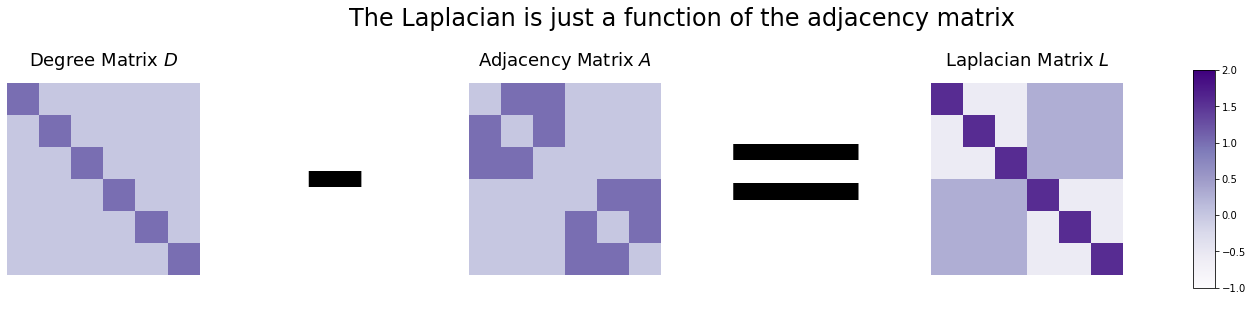

In [25]:
from graphbook_code import heatmap
import seaborn as sns
from matplotlib.colors import Normalize
from graphbook_code import GraphColormap
import matplotlib.cm as cm
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 5, figsize=(25, 5))

# First axis (Degree)
heatmap(D, ax=axs[0], cbar=False, title="Degree Matrix $D$")

# Second axis (-)
axs[1].text(x=.5, y=.5, s="-", fontsize=200, 
            va='center', ha='center')
axs[1].get_xaxis().set_visible(False)
axs[1].get_yaxis().set_visible(False)
sns.despine(ax=axs[1], left=True, bottom=True)

# Third axis (Adjacency matrix)
heatmap(A, ax=axs[2], cbar=False, title="Adjacency Matrix $A$")

# Third axis (=)
axs[3].text(x=.5, y=.5, s="=", fontsize=200,
            va='center', ha='center')
axs[3].get_xaxis().set_visible(False)
axs[3].get_yaxis().set_visible(False)
sns.despine(ax=axs[3], left=True, bottom=True)

# Fourth axis
heatmap(L, ax=axs[4], cbar=False, title="Laplacian Matrix $L$")

# Colorbar
vmin, vmax = np.array(L).min(), np.array(L).max()
norm = Normalize(vmin=vmin, vmax=vmax)
im = cm.ScalarMappable(cmap=GraphColormap("sequential").color, norm=norm)
fig.colorbar(im, ax=axs, shrink=0.8, aspect=10);

fig.suptitle("The Laplacian is just a function of the adjacency matrix", fontsize=24);

## Finding Singular Vectors With Singular Value Decomposition

Now that you have a Laplacian matrix, you'll want to find its singular vectors. To do this, you'll need to use a technique called *Singular Value Decomposition*, or SVD. 

SVD is a way to break a single matrix apart (also known as factorizing) into three distinct new matrices -- In your case, the matrix will be the Laplacian you just built. These three new matrices correspond to the singular vectors and singular values of the original matrix: the algorithm will collect all of the singular vectors as columns of one matrix, and the singular values as the diagonals of another matrix.


```{admonition} Singular-Value Decomposition (SVD) of a real, square matrix
The singular value decomposition of a matrix $X$ whose entries are all real with $n$ rows and $n$ columns is the set of matrices $U, \Sigma$, and $V$, where:
\begin{align*}
    P &= U\Sigma V^\top
\end{align*}
where $U$, $\Sigma$, and $V$ have some special properties:
1. The left singular vectors: the columns $\vec u_i$ of $U$ are called the left singular vectors of $X$. If $X$ has $n$ rows and $n$ columns, there will be $n$ left singular vectors. This matrix looks like this:
\begin{align*}
    U &= \begin{bmatrix}
        \uparrow & & \uparrow \\
        \vec u_1 & ... & \vec u_n \\
        \downarrow & & \downarrow
    \end{bmatrix}
\end{align*}
$U$ is also orthonormal, which you will learn more about [later in this Chapter](#link?). What we need to know about *orthonormality* for now is that this means that none of the columns of $U$ can be expressed as sums of other columns of $U$, or their multiples. We will bring this fact up again later when it comes up.

2. The singular values: the matrix $\Sigma$ is a diagonal matrix, which means that it has entries along the diagonal and all the other entries are just *zero*. There will be $n$ total of these. This matrix looks something like this:
\begin{align*}
    \Sigma &= \begin{bmatrix}
        \sigma_1 & 0 & ... & 0 \\
        0 & \sigma_2 & \ddots & \vdots \\
        \vdots & \ddots & \ddots & 0 \\
        0 & ... & 0 & \sigma_n
    \end{bmatrix}
\end{align*}
The special property is that by definition, the singular values are *descending*, in that $\sigma_1 \geq \sigma_2$, $\sigma_2 \geq \sigma_3$, so on and so forth to $\sigma_n$.

3. The right singular vectors: the columns $\vec v_i$ of $V$ are called the right singular vectors of $X$. If $X$ has $n$ rows and $n$ columns, there will be $n$ right singular vectors. This matrix looks like this:
\begin{align*}
V &= \begin{bmatrix}
        \uparrow & & \uparrow \\
    \vec v_1 & ... & \vec v_n \\
        \downarrow & & \downarrow
\end{bmatrix}
\end{align*}

$V$ is also orthonormal.
```

#### Applying the SVD to the Laplacian

To show this, we'll take the SVD of your Laplacian matrix $L$, and then express $L$ as the matrix product:

In [26]:
U, s, Vt = np.linalg.svd(L)

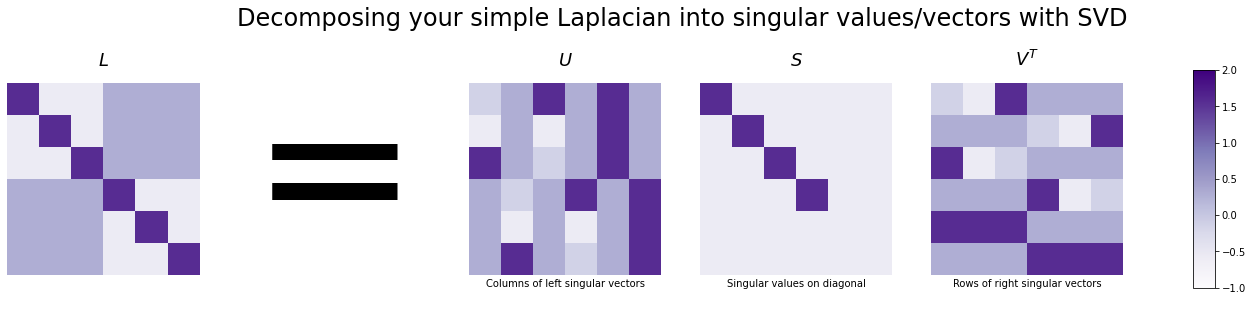

In [42]:
fig, axs = plt.subplots(1, 5, figsize=(25, 5))

# First axis (Laplacian)
heatmap(L, ax=axs[0], cbar=False, title="$L$")

# Second axis (=)
axs[1].text(x=.5, y=.5, s="=", fontsize=200, 
            va='center', ha='center')
axs[1].get_xaxis().set_visible(False)
axs[1].get_yaxis().set_visible(False)
sns.despine(ax=axs[1], left=True, bottom=True)

# Third axis (U)
U_ax = heatmap(U, ax=axs[2], cbar=False, title="$U$")
U_ax.set_xlabel("Columns of left singular vectors")

# Third axis (s)
E_ax = heatmap(np.diag(s), ax=axs[3], cbar=False, title="$S$")
E_ax.set_xlabel("Singular values on diagonal")

# Fourth axis (V^T)
Ut_ax = heatmap(Vt, ax=axs[4], cbar=False, title="$V^T$")
Ut_ax.set_xlabel("Rows of right singular vectors")

# Colorbar
vmin, vmax = np.array(L).min(), np.array(L).max()
norm = Normalize(vmin=vmin, vmax=vmax)
im = cm.ScalarMappable(cmap=GraphColormap("sequential").color, norm=norm)
fig.colorbar(im, ax=axs, shrink=0.8, aspect=10);

fig.suptitle("Decomposing your simple Laplacian into singular values/vectors with SVD", fontsize=24);

### Looking at the Singular Values of $L$ with the scree plot

The first place to start whenever we need a singular value decomposition of a matrix, such as when we compute any spectral embedding, is with something called a scree plot. The **scree plot** just plots the singular values (the diagonal entries of $\Sigma$) by their indices: the first (biggest) singular value is in the beginning, and the last (smallest) singular value is at the end. Let's take a look at what this looks like:

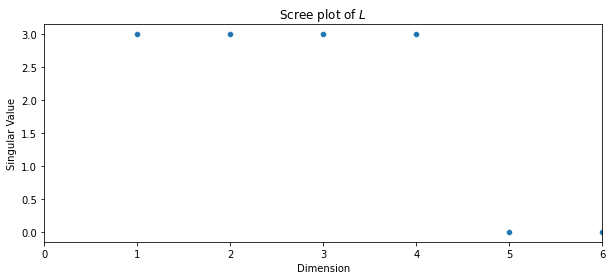

In [43]:
from pandas import DataFrame

def plot_scree(svs, title="", d=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(10, 4))
    sv_dat = DataFrame({"Singular Value": svs, "Dimension": range(1, len(svs) + 1)})
    sns.scatterplot(data=sv_dat, x="Dimension", y="Singular Value", ax=ax)
    ax.set_xlim([0, len(s)])
    ax.set_xlabel("Dimension")
    ax.set_ylabel("Singular Value")
    ax.set_title(title)
    if d is not None:
        ax.axvline(x=d, color='r')
        ax.text(x=d+1, y=svs[d], s="Dimension 2", color='r', size=15)

plot_scree(s, title="Scree plot of $L$")

The first property you will notice is that the singular values are non-increasing: the singular value can never go up as the dimension index increases. This is because by definition of the svd, $\sigma_1 \geq \sigma_2 \geq ... \geq \sigma_n$, which we mentioned as a property of the svd. From what we can see from this plot (and we will need to understand later on) is that there are *four* non-zero, positive singular values for $L$. These are the first four singular values.

## The SVD as a sum of rank-1 matrices

This expression is a little bit complicated, so you will simplify it down a little bit here: as it turns out, this "complicated" looking matrix multiplication is actually pretty straightforward because $\Sigma$ is diagonal. You can write this equation down like this, which is much more understandable:

\begin{align*}
    X &= \sum_{i = 1}^n \sigma_i \vec u_i \vec v_i^\top = \sum_{i = 1}^n \sigma_i\begin{bmatrix}
        \uparrow \\ \vec u_i \\ \downarrow
    \end{bmatrix}\begin{bmatrix}
        \leftarrow & \vec v_i^\top & \rightarrow
    \end{bmatrix}
\end{align*}

Let's try to interpret what this intimitating sum really is saying to us. To start with, for each term, you have the left singular vector, $\vec u_i$. By matrix multiplication, taking the product of $\vec u_i$ with $\vec v_i^\top$ gives you this:
\begin{align*}
    \vec u_i \vec v_i^\top &= \begin{bmatrix}
    \uparrow &  & \uparrow \\
    v_{i1}\vec u_i & ... & v_{in}\vec u_i \\
    \downarrow &  & \downarrow
    \end{bmatrix}
\end{align*}
So basically, you have a matrix with $n$ columns, all of which are multiples of the vector $\vec u_i$. What multiple? Well, that is what $\vec v_i$ tells us: the "amount" of $\vec u_i$ in a particular column $j$ is indicated by $v_{ij}$. This gives you a matrix, $\vec u_i\vec v_i^\top$, which *also* has $n$ rows and $n$ columns, where every row is a multiple of $\vec u_i$. This introduces you to your next important property: *matrix rank*.

```{admonition} Matrix rank
The *rank* of a matrix is a description of just how complicated the matrix is. A matrix is **low rank** if any of its rows (or equivalently, its columns) are linear combinations of other rows (or columns). What this means is that if you can take rows or columns from the matrix, and add or multiply them together to get other rows or columns from the matrix, the matrix is low rank. This means that information contained in the matrix is redundant, in that you could obtain it by just adding or subtracting other information already contained in the matrix if you had instructions as to how to properly combine that information.
```

Since every column of $\vec u_i \vec v_i^\top$ is a multiple of $\vec u_i$, it's pretty clear that the resulting matrix $\vec u_i \vec v_i^\top$ is low rank (it is rank-$1$, since each column is a multiple of the column $\vec u_i$). Finally, you just take this $n$ row and $n$ column matrix, and you multiply the whole thing by $\sigma_i$. So as it turns out, $X$ is equal to a weighted sum of rank-$1$ matrices, where the weights are all given to you by the singular values:
\begin{align*}X &= \sum_{i = 1}^n \sigma_i \vec u_i \vec v_i^\top = \sigma_1\begin{bmatrix}
        \uparrow \\ \vec u_1 \\ \downarrow
    \end{bmatrix}\begin{bmatrix}
        \leftarrow & \vec v_1^\top & \rightarrow
    \end{bmatrix} + ... + \sigma_n\begin{bmatrix}
        \uparrow \\ \vec u_n \\ \downarrow
    \end{bmatrix}\begin{bmatrix}
        \leftarrow & \vec v_n^\top & \rightarrow
    \end{bmatrix}
\end{align*}

### The Laplacian as a sum of rank-$1$ matrices
Let's express this operation using the Laplacian:

In [44]:
n_nodes = L.shape[0]
low_rank_matrices = []
for i in range(0, n_nodes):
    low_rank_matrices.append(s[i]*np.array(U[:,[i]]) @ np.array(Vt[[i],:]))
Lsum = np.sum(low_rank_matrices, axis=0)

AttributeError: 'NoneType' object has no attribute 'get_subplotspec'

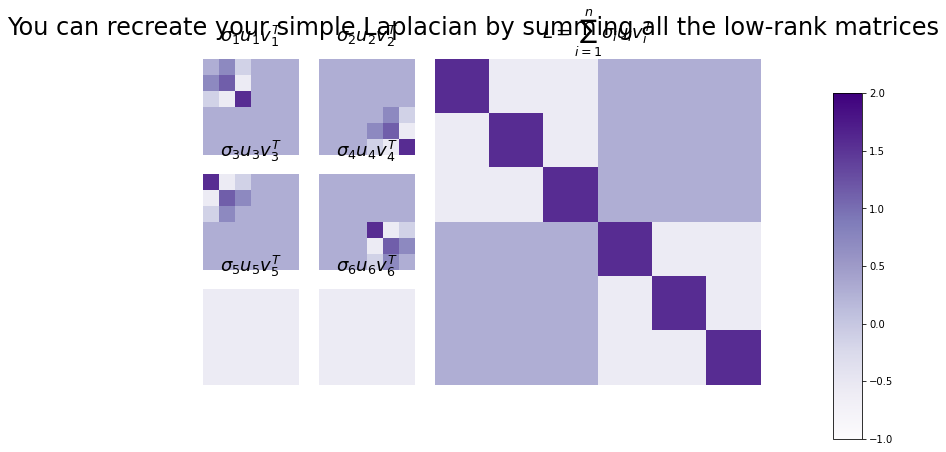

In [46]:
from matplotlib.gridspec import GridSpec
import warnings

fig = plt.figure(figsize=(10, 6))
gs = GridSpec(3, 5)
ax_laplacian = fig.add_subplot(gs[:, 2:])

# Plot low-rank matrices
i = 0
for row in range(3):
    for col in range(2):
        ax = fig.add_subplot(gs[row, col])
        title = f"$\sigma_{i+1} u_{i+1} v_{i+1}^T$"
        heatmap(low_rank_matrices[i], ax=ax, cbar=False, title=title)
        i += 1
        
# Plot Laplacian
heatmap(Lsum, ax=ax_laplacian, cbar=False, title="$L = \sum_{i = 1}^n \sigma_i u_i v_i^T$")

# # Colorbar
cax = fig.add_axes([1, 0, .04, .8])
vmin, vmax = np.array(Lsum).min(), np.array(Lsum).max()
norm = Normalize(vmin=vmin, vmax=vmax)
im = cm.ScalarMappable(cmap=GraphColormap("sequential").color, norm=norm)
fig.colorbar(im, cax=cax, use_gridspec=False);


fig.suptitle("You can recreate your simple Laplacian by summing all the low-rank matrices", fontsize=24)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plt.tight_layout();

## Critical Property of the SVD

You're also going to repeatedly make use of a property of the Singular Value Decomposition, or `svd`, that will be very handy for this section and the next section:

```{admonition} Left/Right Singular Vector equivalences for positive semi-definite matrices
If the matrix $X$ is symmetric and has $K$ real, non-negative singular values, where the remaining $n - K$ singular values are all at least $0$ (it is positive semi-definite, in linear algebra terms), then the top $K$ left and right singular vectors are equal. 

This condition can be met, for instance, by a network Laplacian. The reason the Laplacian meets this criterion exceeds the scope of this book, but we encourage you to check out a Linear Algebra book for further details.
```

For more technical and generalized details on how SVD works, or for explicit proofs, we would recommend a Linear Algebra textbook [Trefethan, LADR]. We'll look at the SVD with a bit more detail here in the specific case where you start with a matrix which is square, symmetric, and has real eigenvalues.

### The Laplacian left/right singular vector equivalence

Next, you'll see that the left and right singular vectors are equivalent for the Laplacian for the non-zero singular values. We take a look at the first four columns of $U$ and $V$, as well as their difference. The reason we look at the first four columns is that these columns are the ones that correspond to the non-zero singular values.  We will quantify the difference between the first four columns of $U$ and $V$ using the *Frobenius norm* of the difference between them. This quantity, abbreviated $||U - V||_F$, has a value greater than $0$ if the two matrices have any entries not in common:

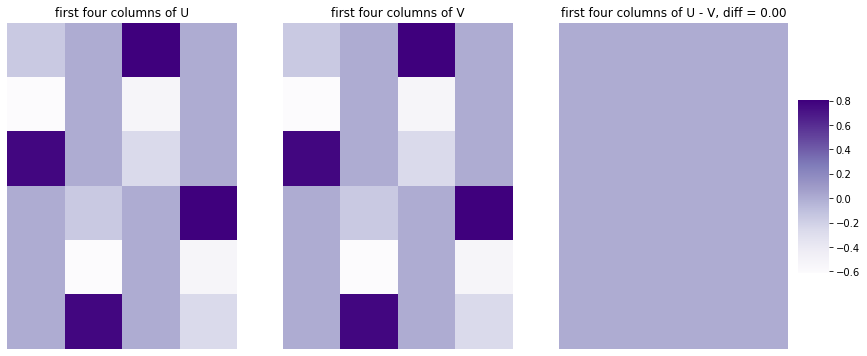

In [47]:
fig, axs = plt.subplots(1, 3, figsize=(14, 6))

Unz = U[:,0:4]; Vtnz = Vt[0:4,:]
vmin, vmax = np.min(np.hstack([U, Vt])), np.max(np.hstack([U, Vt]))
diff = np.linalg.norm(U - Vt.transpose())

cbar_ax = fig.add_axes([.91, .3, .03, .4])

mtxs = [Unz, Vtnz.transpose(), Unz - Vtnz.transpose()]
title = ["first four columns of U", "first four columns of V", "first four columns of U - V, diff = {:.2f}".format(diff)]
for i, ax in enumerate(axs.flat):
    sns.heatmap(mtxs[i], cbar=i == 0, vmin=vmin, vmax=vmax, ax=ax,
           cbar_ax = None if i else cbar_ax, cmap=cmaps["sequential"])
    ax.set_title(title[i])
    ax.set_xticks([]); ax.set_yticks([])

### You can approximate your simple Laplacian by only summing a few of the low-rank matrices

Your expression has simplified down a little bit, but you aren't quite finished. If the Laplacian $L$ has the singular value decomposition with matrix $U$, $\Sigma$, and $V$, then you could express $L$ as:

\begin{align*}
    L &= \sum_{i = 1}^n \sigma_i \vec u_i \vec v_i^\top
\end{align*}
But wait, we know that some of these singular vectors are just redundant: their singular value is zero! And for all of the other left and right singular vectors, we knew that the corresponding singular vectors were exactly equivalent So this means that, if the first $K$ singular values are non-zero, that:
\begin{align*}
    L &= \sum_{i = 1}^K \sigma_i\vec u_i \vec u_i^\top
\end{align*}
For each term in this sum, remember we said that we had a rank-$1$ matrix whose columns are multiples of $\vec u_i$ (where the exact multiplicative factor was given by $\vec v_i$, but now is also given by $\vec u_i$ since $\vec u_i = \vec v_i$ for these vectors with non-zero singular values) weighted by $\sigma_i$. What do we mean by *weighted* here?

To better understand this term, we'll use a few facts. Remember that we said that the Laplacian had positive singular values, which means that their sum, $s = \sum_{i = 1}^n \sigma_i$, is also positive. Let's rewrite your expression a tiny bit:
\begin{align*}
    L &= \sum_{i = 1}^K s\frac{\sigma_i}{s}\vec u_i \vec v_i^\top \\
    &= s\sum_{i = 1}^K \frac{\sigma_i}{s}\vec u_i \vec v_i^\top
\end{align*}
All you have done here is used the fact that $\frac{s}{s} = 1$, so you basically just *pulled out* a term of $s$ from every element.

Now you can start to understand this expression a little bit better. Notice that since the singular values are positive, that the term $\frac{\sigma_i}{s}$ is going to be a fraction for every singular value/vector (it will be between $0$ and $1$). To take it a step further, the sum of all of these terms will, in fact, be $1$! That is:
\begin{align*}
    \sum_{i = 1}^K \frac{\sigma_i}{s} = 1
\end{align*}
This is because you could pull out the common factor $\frac{1}{s} = \frac{1}{\sum_{i = 1}^n \sigma_i}$ from every element of the sum, and then you are just left with:
\begin{align*}
    \frac{1}{\sum_{i = 1}^K \sigma_i}\sum_{i = 1}^n \sigma_i = 1
\end{align*} 
So in a sense, the quantity $\frac{\sigma_i}{s}$ tells you the *fraction* of $L$ that is *explained* by $\vec u_i \vec u_i^\top$. This quantity represents how much of $\vec u_i \vec u_i^\top$ you need to include in order to obtain $L$. But there's another fun fact: remember that the singular values were all ordered in *decreasing* order! This meant that $\sigma_1 \geq \sigma_2 \geq ... \geq \sigma_K$. So, if you just add $\frac{1}{s}$ to each of these, since $s$ is positive, $\frac{1}{s}$ will be too, and consequently, $\frac{\sigma_1}{s} \geq \frac{\sigma_2}{s} \geq ... \geq \frac{\sigma_K}{s}$!

What this means is that to describe $L$, you need *more* of the first few singular vectors than you do of the later singular vectors. These singular vectors will comprise a bigger *fraction* of $L$ than the others.

Logically, if you wanted to take $L$ and form a *best* representation with only a single rank-$1$ matrix, wouldn't it make a lot of sense to take the rank-$1$ matrix which was the largest fraction of $L$? And if you wanted to take $L$ and form the *best* representation with a rank-$2$ matrix, what could you do there? 

You will remember we brought up a fact about $U$: it was orthonormal, which meant that the columns $\vec u_i$ were not sums of other columns nor their multiples. This means that to understand a sum of any two different rank-$1$ matrices $\sigma_i\vec u_i\vec u_i^\top$ and $\sigma_j\vec u_j\vec u_j^\top$ for some combination $i$ and $j$ that make up $L$ be rank-$2$: you cannot express $\vec u_i$ as a multiple of $\vec u_j$, and vice-versa. 

So then to get the best rank-$2$ representation of $L$, wouldn't it make sense for you to take the two rank-$1$ matrices that were the largest and second largest fraction of $L$? We think so too! This pattern, coupled with the orthonormality of $U$, gives us that $L_d$ is a rank-$d$ representation of $L$ as long as the singular values are non-zero.

As it turns out, for a Laplacian, the best rank-$d$ representation is the quantity:
\begin{align*}
    L_d &= \sum_{i = 1}^d \sigma_i \vec u_i \vec u_i^\top
\end{align*}
When we say best here, we mean the representation where the Frobenius norm of the difference (there's that term again!) $||L - L_d||_F$ is at a minimum. In this sense, $L_d$ is the best rank-$d$ *approximation* of the original matrix $L$. A similar property holds in general for *any* svd, with a lot fewer restrictions than we've placed here (without needing the left and right singular vectors to be equivalent), but this will suffice intuitionally for your purposes that you need going forward. We have the convenient intuition that each successive rank-$1$ matrix we are adding is a lower and lower *fraction* of $L$, which does not quite hold for the more general case of an svd.

This tells you something interesting about Spectral Embedding: the information in the first few singular vectors of a high rank matrix lets you find a more simple approximation to it. You can take a matrix that's extremely complicated (high-rank) and project it down to something which is much less complicated (low-rank).

Look below. In each plot, we're summing more and more of these low-rank matrices. By the time you get to the fourth sum, we've totally recreated the original Laplacian, and the remaining terms don't even matter.

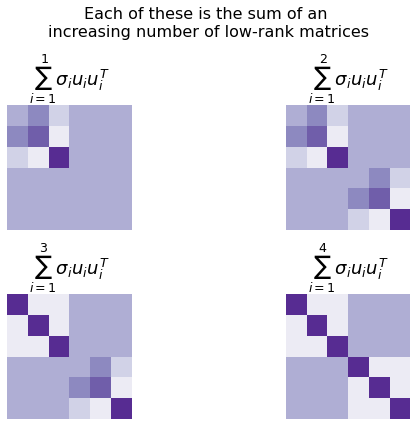

In [45]:
fig, axs = plt.subplots(2, 2, figsize=(9,6))

current = np.zeros(L.shape)
for i, ax in enumerate(axs.flat):
    new = low_rank_matrices[i]
    current += new
    heatmap(current, ax=ax, cbar=False, 
            title=f"$\sum_{{i = 1}}^{i+1} \sigma_i u_i u_i^T$")
    
fig.suptitle("Each of these is the sum of an \nincreasing number of low-rank matrices", fontsize=16)
plt.tight_layout()

### Approximating becomes extremely useful when you have a bigger (now regularized) Laplacian

This becomes even more useful when you have huge networks with thousands of nodes, but only a few communities. It turns out, especially in this situation, you can usually sum a very small number of low-rank matrices and get to an excellent approximation for your network that uses much less information.

Take the network below, for example. It's generated from a Stochastic Block Model with 50 nodes total (25 in one community, 25 in another). You took its normalized Laplacian (remember that this means $L = D^{-1/2} A D^{-1/2}$), decomposed it, and summed the first two low-rank matrices that you generated from the singular vector columns.

The result is not exact, but it looks pretty close. And you only needed the information from the first two singular vectors instead of all of the information in your full $n \times n$ matrix! 

In [ ]:
from graspologic.simulations import sbm
from graspologic.utils import to_laplacian

# Make network
B = np.array([[0.8, 0.1], 
              [0.1, 0.8]])
n = [25, 25]
A2, labels2 = sbm(n=n, p=B, return_labels=True)

# Form new laplacian
L2 = to_laplacian(A2)

# decompose
k = 2
U2, E2, Ut2 = svd(L2)

k_matrices = U2[:, k]
low_rank_approximation = U2[:,0:k] @ (np.diag(E2[0:k]) @ Ut2[0:k, :])


# Plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
l2_hm = heatmap(L2, ax=axs[0], cbar=False, title="$L$")
l2approx_hm = heatmap(low_rank_approximation, ax=axs[1], cbar=False, title="$L_2 = \sum_{{i = 1}}^{2} \sigma_i u_i u_i^T$")

l2_hm.set_xlabel("Full-rank Laplacian for a 50-node matrix", fontdict={'size': 15})
l2approx_hm.set_xlabel("Sum of only two low-rank matrices", fontdict={'size': 15});

fig.suptitle("Summing only two low-rank matrices approximates the normalized Laplacian pretty well!", fontsize=24)

plt.tight_layout()

This is where a lot of the power of an SVD comes from: you can approximate extremely complicated (high-rank) matrices with extremely simple (low-rank) matrices.

## Using the SVD to understand the latent position matrix

So, now we've taken your Laplacian $L$, and we've reduced it down to the most important $d$ low-rank matrices. You expressed $L_d$ as:
\begin{align*}
    L_d &= \sum_{i = 1}^d\sigma_i \vec u_i \vec u_i^\top
\end{align*}
To keep the fun going, we're going to back up a step. To do this, we'll introduce two new matrices, $\Sigma_d$ and $U_d$. In this case, $\Sigma_d$ is going to be a $d \times d$ diagonal matrix, whose diagonal entries are the top $d$ singular values of $L$, and $U_d$ is going to be the $n \times d$ matrix whose columns are the corresponding top $d$ singular vectors of $L$. These matrices look like this:
\begin{align*}
    U_d &= \begin{bmatrix}
    \uparrow & & \uparrow \\
    \vec u_1 & ... & \vec u_d \\
    \downarrow & & \downarrow
    \end{bmatrix},\;\;\; \Sigma_d = \begin{bmatrix}
        \sigma_1 & 0 & ... & 0\\
        0 & \sigma_2 & \ddots & \vdots \\
        \vdots & \ddots & \ddots & 0 \\
        0 & ... & 0 & \sigma_d
    \end{bmatrix}
\end{align*}
As it turns out, just like you expressed the product $U\Sigma V^\top$ as a sum, you can do the reverse here, too: you can express the above sum for $L_d$ as a matrix product, by writing that $L_d = U_d \Sigma_d U_d^\top$. Why does this help us?

You know that the singular values for a Laplacian are non-negative, so they all have a square root. This means you could express $\sigma_i$ as the product of $\sqrt{\sigma_i}\sqrt{\sigma_i}$ with itself!

Finally, remember that if you were to multiply two diagonal matrices, the resulting matrix would just be the element-wise product of each diagonal entry. This means you could just write $\Sigma_d$ like this:
\begin{align*}
    \Sigma_d &= \begin{bmatrix}
        \sqrt{\sigma_1} & 0 & ... & 0 \\
        0 & \sqrt{\sigma_2} & \ddots & \vdots \\
        \vdots & \ddots & \ddots & 0 \\
        0 & ... & 0 & \sqrt{\sigma_d}
    \end{bmatrix}\begin{bmatrix}
        \sqrt{\sigma_1} & 0 & ... & 0 \\
        0 & \sqrt{\sigma_2} & \ddots & \vdots \\
        \vdots & \ddots & \ddots & 0 \\
        0 & ... & 0 & \sqrt{\sigma_d}
    \end{bmatrix}
\end{align*}
You will call the resulting matrix the "square root" matrix of $\Sigma_d$, abbreviated $\sqrt{\Sigma_d}$ which hopefully is named for pretty obvious reasons. So, $\Sigma_d = \sqrt{\Sigma_d}\sqrt{\Sigma_d}$. This matrix has $d \times d$ entries, and is therefore square. Also, notice that all the off-diagonal entries are just $0$, which means it's symmetric too, because of the convenient fact that $0 = 0$ (and hence, the off-diagonal entries are all equal). Putting this fact together means that $\sqrt{\Sigma_d} = \sqrt{\Sigma_d}^\top$, which is the definition of matrix symmetry. So finally, $\Sigma_d = \sqrt{\Sigma_d}\sqrt{\Sigma_d}^\top$. This gives you that:
\begin{align*}
    L_d &= U_d \sqrt{\Sigma_d}\sqrt{\Sigma_d}^\top U_d^\top
\end{align*}
Or stated another way, if you call $\hat X_d = U_d \sqrt{\Sigma_d}$, then $L_d = \hat X_d \hat X_d^\top$. This means that the matrix $X_d$ contains *all* of the information you need to describe $L_d$.

Since $\hat X_d$ contains all the information you need to study $L_d$, why wouldn't you just study $\hat X_d$ itself? This is exactly what you do. Because $\hat X_d$ is so important, you give it a special name: you call $\hat X_d$ a rank-$d$ estimate of the **latent positions of the Laplacian**. It looks like this:
\begin{align*}
    \hat X_d &= U_d \sqrt{\Sigma_d} = \begin{bmatrix}
        \uparrow & & \uparrow \\
        \sqrt{\sigma_1}\vec u_1 & ... & \sqrt{\sigma_d}\vec u_d \\
        \downarrow & & \downarrow
    \end{bmatrix}
\end{align*}

It is rank-$d$ because it has $d$ unique columns, called the estimates of the latent dimensions of $L$. These columns are the unique vectors $\vec u_i$ that you needed to best describe $L$, and then weighted by just how important they were $\sqrt{\sigma_i}$.

## How This Matrix Rank Stuff Helps you Understand Spectral Embedding

Let's go back to your original, small (six-node) network and make an estimate of the latent position matrix from it. You'll embed down to two dimensions.

In [ ]:
d = 2
Ud = U[:, :d]
Sdsqrt = np.sqrt(np.diag(s[:d]))

Xhat = Ud @ Sdsqrt

In [ ]:
fig, ax = plt.subplots(figsize=(4, 8))
cmap = cmaps["sequential"]
ax = sns.heatmap(Xhat, cmap=cmap, ax=ax, cbar=False, 
                 xticklabels=["$\\sqrt{\\sigma_1}\\vec u_1$", "$\\sqrt{\\sigma_2}\\vec u_2$",
                              "$\\sqrt{\\sigma_3}\\vec u_3$"], yticklabels=1)
ax.set_xlabel("Latent Dimension")
ax.set_ylabel("Node")

ax.set_title("Estimate of Latent Position Matrix $\\hat X_3$", fontsize=22, y=1.01)

plt.tight_layout();

When you want to study the network, you can look at the estimate of the latent positions of the Laplacian, $\hat X_d$. This is called investigating the **Laplacian Spectral Embedding** of the network, and is a crucial technique to understanding a network.

## Adjacency Spectral Embedding

As it turns out, you can learn a lot about a network without needing to take its Laplacian, too: you could have just spectrally embedded the adjacency matrix alone, and there would be lots of information for you to learn. In fact, most of the cool, intuitive results you used here will come in handy when you study the adjacency spectral embedding, too (with some minor alterations due to differences in the properties of an adjacency matrix compared to a Laplacian matrix). However, this procedure, known as an Adjacency Spectral Embedding, will tie directly into a concept you learned about previously, the RDPG, so you will break it out into its own special section for [Estimating parameters from RDPGs](#link?) so you can understand it in greater detail. 

## Figuring Out How Many Dimensions To Embed Your Network Into

One thing we haven't addressed is how to figure out how many dimensions to embed down to. You've generally been embedding into two dimensions throughout this chapter (mainly because it's easier to visualize), but you can embed into as many dimensions as you want.

If you don't have any prior information about the "true" dimensionality of your latent positions, by default you'd just be stuck guessing. Fortunately, there are some rules-of-thumb to make your guess better, and some methods people have developed to make fairly decent guesses automatically.

The most common way to pick the number of embedding dimensions is with the same scree plot we looked at earlier. Essentially, the intuition is this: the top singular vectors of an adjacency matrix contain the most useful information about your network, and as the singular vectors have smaller and smaller singular values, they contain less important and so are less important (this is why we're allowed to cut out the smallest $n-k$ singular vectors in the spectral embedding algorithm).

You can see the scree plot for the Laplacian you made earlier below. We're only plotting the first ten singular values for demonstration purposes.

In [ ]:
# from graspologic.plot import screeplot
from matplotlib.patches import Circle
from matplotlib.patheffects import withStroke
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredDrawingArea
from scipy.linalg import svdvals

fig, ax = plt.subplots(figsize=(8, 5))

# eigval plot
D = svdvals(L2)
ax.plot(D[:10])
ax.set_xlabel("Singular value index")
ax.set_ylabel("Singular value")

# plot circle
x, y = .15, .15
radius = .15
ada = AnchoredDrawingArea(150, 150, 0, 0, loc='lower left', pad=0., frameon=False)
circle = Circle((105, 35), 20, clip_on=False, zorder=10, linewidth=1,
                edgecolor='black', facecolor=(0, 0, 0, .0125),
                path_effects=[withStroke(linewidth=5, foreground='w')])
ada.da.add_artist(circle)
ax.add_artist(ada)

# add text
def text(x, y, text):
    ax.text(x, y, text, backgroundcolor="white",
            ha='center', va='top', color='blue')
    
text(2, .19, "Elbow")

You'll notice that there's a marked area called the "elbow". This is an area where singular values stop changing in magnitude as much when they get smaller: before the elbow, singular values change rapidly, and after the elbow, singular values barely change at all. (It's called an elbow because the plot kind of looks like an arm, viewed from the side!)

The location of this elbow gives you a rough indication for how many "true" dimensions your latent positions have. The singular values after the elbow are quite close to each other and have singular vectors which are largely noise, and don't tell you very much about your data. It looks from the scree plot that you should be embedding down to two dimensions, and that adding more dimensions would probably just mean adding noise to your embedding.

One drawback to this method is that a lot of the time, the elbow location is pretty subjective - real data will rarely have a nice, pretty elbow like the one you see above. The advantage is that it still generally works pretty well; embedding into a few more dimensions than you need isn't too bad, since you'll only have a few noies dimensions and there still may be *some* signal there.

In any case, Graspologic automates the process of finding an elbow using a popular method developed in 2006 by Mu Zhu and Ali Ghodsi at the University of Waterloo. We won't get into the specifics of how it works here, but you can usually find fairly good elbows automatically.

## Using Graspologic to embed networks

It's pretty straightforward to use graspologic's API to embed a network. The setup works like an SKlearn class: you instantiate an AdjacencySpectralEmbed class, and then you use it to transform data. You set the number of dimensions to embed to (the number of singular vector columns to keep!) with `n_components`, or alternatively, let this value be selected automatically with elbow selection. We'll show how to use Adjacency Spectral Embedding where you know the right number of dimensions to use is $2$, and Laplacian Spectral Embedding where you let elbow selection pick for us.

### Adjacency Spectral Embedding

In [ ]:
from graspologic.embed import AdjacencySpectralEmbed as ASE

# Generate a network from an SBM
B = np.array([[0.8, 0.1], 
              [0.1, 0.8]])
n = [25, 25]
A, labels = sbm(n=n, p=B, return_labels=True)

# Instantiate an ASE model and find the embedding
ase = ASE(n_components=2)
embedding = ase.fit_transform(A)

In [ ]:
plot_latents(embedding, labels=labels, title="Adjacency Spectral Embedding");

### Laplacian Spectral Embedding

Here, you'll let elbow selection do the work for us, by not selecting any number of latent dimensions ahead of time.

In [ ]:
from graspologic.embed import LaplacianSpectralEmbed as LSE

embedding = LSE().fit_transform(A)

In [ ]:
print("Estimated number of latent dimensions: {:d}".format(lse.n_components_))

plot_latents(embedding, labels=labels, title="Laplacian Spectral Embedding");

## When should you use ASE and when should you use LSE?

Throughout this article, we've primarily used LSE, since Laplacians have some nice properties (such as having singular values being the same as singular values) that make stuff like SVD easier to explain. However, you can embed the same network with either ASE or LSE, and you'll get two different (but equally true) embeddings.

Since both embeddings will give you a reasonable clustering, how are they different? When should you use one compared to the other?

Well, it turns out that LSE and ASE capture different notions of "clustering". Carey Priebe and collaborators at Johns Hopkins University investigated this recently - in 2018 - and discovered that LSE lets you capture "affinity" structure, whereas ASE lets you capture "core-periphery" structure (their paper is called "On a two-truths phenomenon in spectral graph clustering" - it's an interesting read for the curious). The difference between the two types of structure is shown in the image below.


```{figure} ../../Images/two-truths.jpeg
---
height: 400px
name: two-truths
---
Affinity vs. Core-periphery Structure 
```

The "affinity" structure - the one that LSE is good at finding - means that you have two groups of nodes which are well-connected within the groups, and aren't very connected with each other. Think of a friend network in two schools, where people within the same school are much more likely to be friends than people in different schools. This is a type of structure we've seen a lot in this book in your Stochastic Block Model examples. If you think the communities in your data look like this, you should apply LSE to your network.

The name "core-periphery" is a good description for this type of structure (which ASE is good at finding). In this notion of clustering, you have a core group of well-connected nodes surrounded by a bunch of "outlier" nodes which just don't have too many edges with anything in general. Think of a core of popular, well-liked, and charismatic kids at a high school, with a periphery of loners or people who prefer not to socialize as much.